In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv("/content/drive/MyDrive/NLP/IMDB Dataset.csv")

In [3]:
document = df['review']

In [4]:
# data cleaning
def cleaned_text(text):
  text = text.lower()
  text = re.sub('[^a-zA-Z]\s', ' ', text)  # Sadece harf ve boşluk bırak
  text = re.sub('\d', ' ', text)  # Rakamları kaldır
  text = " ".join([word for word in text.split() if len(word)>2])
  text = re.sub(r'\s+', ' ',text) # # Birden fazla boşluğu tek bir boşlukla değiştir

  # stop words
  stop_words = set(stopwords.words('english'))
  text = " ".join([word for word in text.split() if word not in stop_words])

  return text

In [5]:
# example
text = cleaned_text("HeLloo !! tHis iS a wORld emBedding  &   noteBOOK %%/ $ ")
print(f"Text:{text}")

Text:helloo world embedding notebook


In [6]:
# cleaning dataset
cleaned_document = [cleaned_text(doc) for doc in document]

In [7]:
cleaned_document[0][0:30]

'one reviewers mentioned watchi'

**tokenization**

In [8]:
# tokenization
tokenized_document = [simple_preprocess(doc) for doc in cleaned_document]

In [9]:
tokenized_document[0][0:10]

['one',
 'reviewers',
 'mentioned',
 'watching',
 'episode',
 'hooked',
 'right',
 'exactly',
 'happened',
 'me']

**Word2Vec model: Önceden eğitilmiş kelimeler için vektörler sağlar**

* Hazır Word2Vec modeline kendi tokenize edilmiş datasetimizi veriyoruz.
* Bu model, kelimeler arasındaki anlam ilişkilerini öğrenerek her kelimeyi bir vektörle temsil eder.
* Kodda, modeldeki kelimelerin vektör karşılıklarını alıyoruz.

In [10]:
Word2Vec_model = Word2Vec(sentences=tokenized_document, vector_size=50, window=5, min_count=1, sg=0)
word_vectors = Word2Vec_model.wv # Kelime vektörlerine erişim

words = list(word_vectors.index_to_key) # modelin öğrendiği kelimelerin bir listesini döndürür
vectors = [word_vectors[word] for word in words] # words listesindeki her kelime için o kelimenin vektörünü alıyoruz.

**Clustering KMeans K=2**

* Kelime vektörlerini kullanarak kümeleme (clustering) işlemi. Buradaki amaç, kelimeleri benzerliklerine göre kümelere ayırmak.
* kmeans.labels_ : Bu özellik, her kelimenin hangi kümeye ait olduğunu belirten etiketleri içerir. Yani, her kelimeye bir kume numarası atanır.
* kümelemenin amacı: görselleştirirken kolaylık sağlaması

In [11]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(vectors)
clusters = kmeans.labels_
print(clusters)
print(f"clusters: {np.unique(clusters)}")

[0 0 0 ... 0 0 0]
clusters: [0 1]


In [12]:
'''
50 boyutta cluster yapılır sonra 2 boyuta düşürülür.
'''

'\n50 boyutta cluster yapılır sonra 2 boyuta düşürülür.\n'

**PCA: principle component analysis**

vector_size: 50 -> 2

In [13]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

In [14]:
print(reduced_vectors[0:5])

[[-3.43129085 -1.43273265]
 [-6.74339534 -2.49708775]
 [-5.57977825 -2.43687574]
 [-3.32110388 -2.19584957]
 [-2.62177336 -1.77837636]]


**visualization 2D**

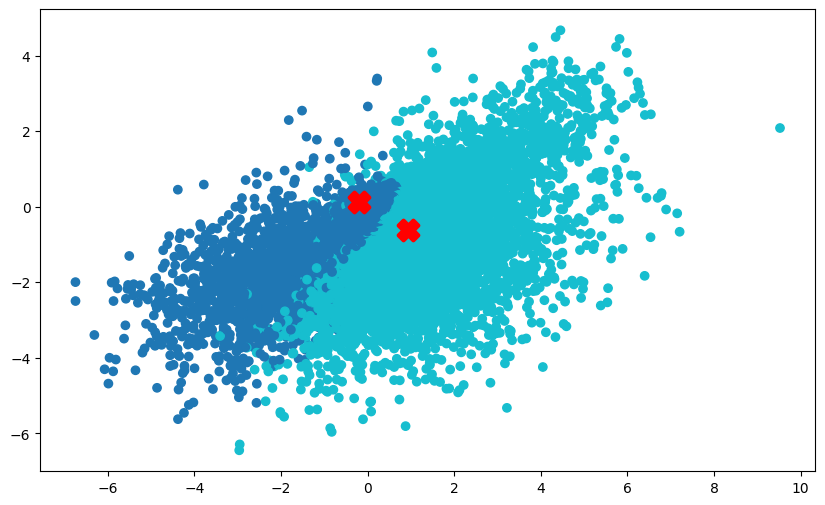

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters, cmap='tab10')
# scatter(x,y,c,cmap)
centers = pca.transform(kmeans.cluster_centers_)
centers # kümelerin merkezleri(x,y)
plt.scatter(centers[:, 0], centers[:, 1], marker='X', s=200, linewidths=3, color='red')
plt.show()

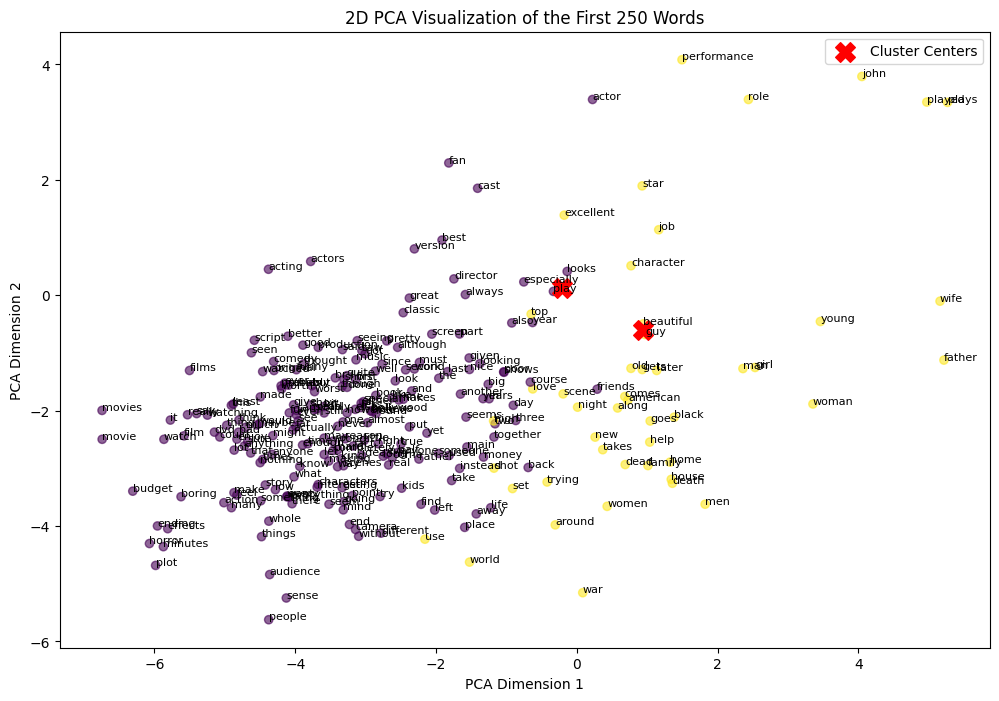

In [16]:
# Select the first 250 words
num_words = 250
words_subset = words[:num_words]
vectors_subset = reduced_vectors[:num_words]

# Scatter plot with word labels
plt.figure(figsize=(12, 8))
plt.scatter(vectors_subset[:, 0], vectors_subset[:, 1], c=clusters[:num_words], cmap='viridis', alpha=0.6)

# Add text labels for the first 250 words
for i, word in enumerate(words_subset):
    plt.text(vectors_subset[i, 0], vectors_subset[i, 1], word, fontsize=8)

# Show cluster centers
plt.scatter(centers[:, 0], centers[:, 1], color="red", marker="X", s=200, label="Cluster Centers")

plt.legend()
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title(f"2D PCA Visualization of the First {num_words} Words")
plt.show()